In [30]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from prince import MCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Prepare data

In [31]:
# Nạp dữ liệu
jobs = pd.read_csv("../data/clean_data_train.csv")
jobs = jobs.drop(columns=['Sex', 'Contract Type'])
jobs.head()

,Salary,Level,Year of Experience,Programming Language,Requirement Language,Description Language,Location
0,20500000.0,Nhân viên,2 năm,java,tiếng anh,vi,Hà Nội
1,36500000.0,Nhân viên,2 năm,Khác,tiếng anh,en,Hồ Chí Minh
2,22500000.0,Trưởng/Phó phòng,2 năm,Khác,Không yêu cầu,vi,Hà Nội
3,22500000.0,Trưởng nhóm,3 năm,Khác,Không yêu cầu,vi,Hà Nội
4,30000000.0,Nhân viên,3 năm,php,Không yêu cầu,vi,Hà Nội


# 2. Encoding

In [32]:
jobs_encoding = jobs.copy()

In [33]:
# Lưu lại cột Salary trước khi chuẩn hóa và phân cụm
salaries = jobs_encoding['Salary']
jobs_encoding = jobs_encoding.drop(columns=['Salary'])

In [34]:
encoder = OrdinalEncoder(categories=[['Thực tập sinh', 'Nhân viên', 'Trưởng nhóm', 'Trưởng/Phó phòng', 'Quản lý / Giám sát', 'Giám đốc']])
encoded_level = encoder.fit_transform(jobs_encoding[['Level']])
jobs_encoding['Level'] = encoded_level

In [35]:
encoder = OrdinalEncoder(categories=[['vi', 'en']])
encoded_l = encoder.fit_transform(jobs_encoding[['Description Language']])
jobs_encoding['Description Language'] = encoded_l

In [36]:
encoder = OrdinalEncoder(categories=[['Không yêu cầu kinh nghiệm', 'Dưới 1 năm', '1 năm', '2 năm', '3 năm', '4 năm', '5 năm', 'Trên 5 năm']])
encoded_YoE = encoder.fit_transform(jobs_encoding[['Year of Experience']])
jobs_encoding['Year of Experience'] = encoded_YoE

In [37]:
#LabelEncoding
le = LabelEncoder()
for col in jobs_encoding.select_dtypes(include=['object']).columns:
    jobs_encoding[col] = le.fit_transform(jobs_encoding[col])

In [38]:
jobs_encoding.head()

,Level,Year of Experience,Programming Language,Requirement Language,Description Language,Location
0,1.0,3.0,5,1,0.0,0
1,1.0,3.0,0,1,1.0,1
2,3.0,3.0,0,0,0.0,0
3,2.0,4.0,0,0,0.0,0
4,1.0,4.0,8,0,0.0,0


# 3. Clustering

In [39]:
jobs_clustering = jobs_encoding

In [40]:
# Áp dụng MCA
mca = MCA(n_components=2, random_state=42)
jobs_clustering_mca = pd.DataFrame(mca.fit_transform(jobs_clustering))

# Đổi tên cột
jobs_clustering_mca.columns = ['MCA1', 'MCA2']
jobs_clustering_mca.head()

,MCA1,MCA2
0,0.099762,-0.294152
1,0.917549,0.233957
2,-0.231137,-0.447360
3,0.279445,-0.198922
4,0.103507,-0.317054


In [41]:
def choose_K(data, K_range = range(2,9)):
    Sum_of_squared_distances = []
    K = K_range
    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        kmeans.fit(data)
        Sum_of_squared_distances.append(kmeans.inertia_)

    plt.plot(K,Sum_of_squared_distances,'x-')
    plt.xlabel('Values of K')
    plt.ylabel('Sum of squared distances/Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

- Sử dụng phương pháp Elbow để xác định số cụm tối ưu

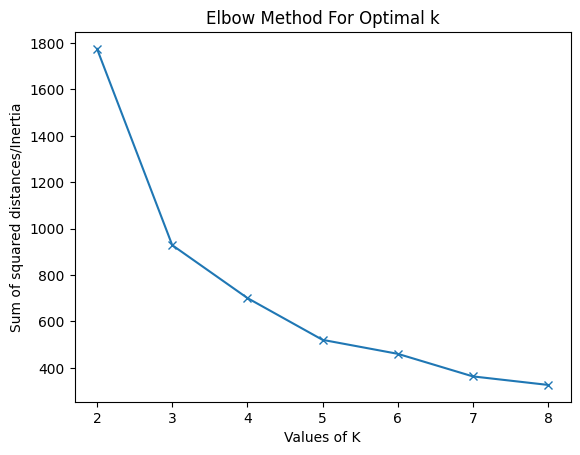

In [42]:
choose_K(jobs_clustering_mca)

- Dùng Silhouette Score để đánh giá chất lượng phân cụm

In [43]:
def evaluate(data: pd.DataFrame, range_n_clusters = range(2, 9)):
    silhouette_avg = []
    for num_clusters in range_n_clusters:
        # initialise kmeans
        kmeans = KMeans(n_clusters=num_clusters)
        kmeans.fit(data)
        cluster_labels = kmeans.labels_
        # silhouette score
        silhouette_avg.append(silhouette_score(data, cluster_labels))

    plt.plot(range_n_clusters,silhouette_avg,'x-')
    plt.xlabel('Values of K')
    plt.ylabel('Silhouette score')
    plt.title('Silhouette analysis For Optimal k')
    plt.show()

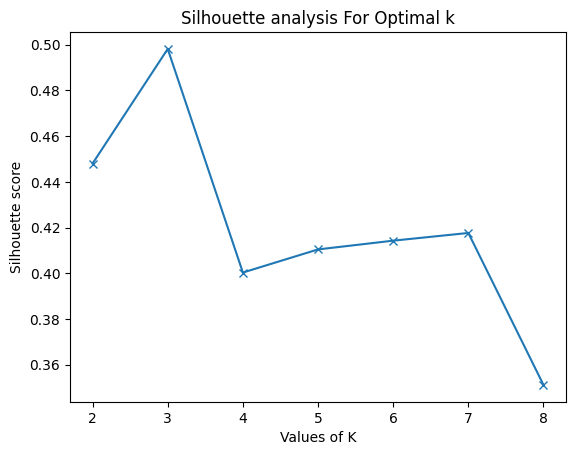

In [44]:
evaluate(jobs_clustering_mca)

In [45]:
# From above analysis for optimal value of k
K = 3

<Axes: xlabel='MCA1', ylabel='MCA2'>

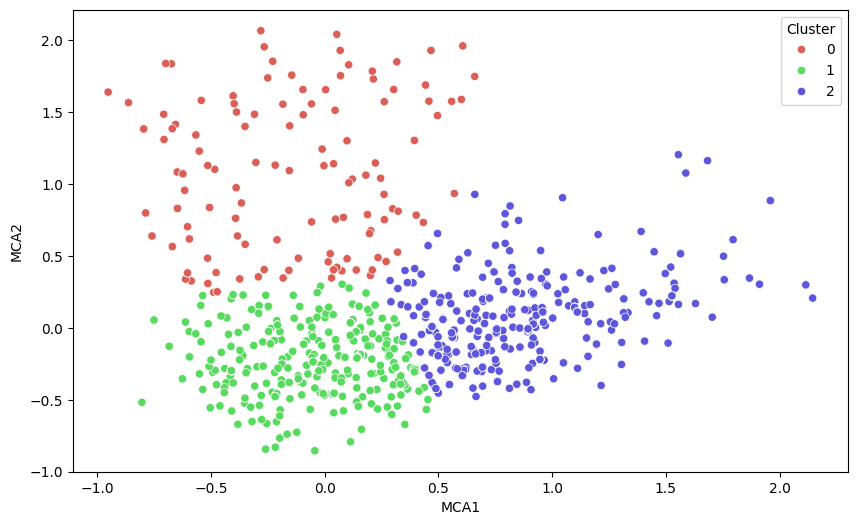

In [46]:
kmeans = KMeans(n_clusters=K, init='k-means++', random_state=42)
kmeans.fit(jobs_clustering_mca)
pred = kmeans.predict(jobs_clustering_mca)
jobs_clustering_mca = pd.DataFrame(jobs_clustering_mca, columns = ['MCA1','MCA2']) # features selected by using MCA
jobs_clustering_mca['Cluster'] = pred

# Plot Showing Clusters using features [2] selected from MCA
plt.figure(figsize=(10,6))
sns.scatterplot(data=jobs_clustering_mca, x=jobs_clustering_mca.MCA1, y=jobs_clustering_mca.MCA2, hue='Cluster', palette=sns.color_palette("hls", K), legend="full")

In [47]:
jobs_cluster_result = jobs.copy()
jobs_cluster_result['Cluster'] = pred

In [48]:
def define_cluster(data, cluster):
    return data[data['Cluster'] == cluster]

- Lưu lại kết quả phân cụm

In [49]:
def save_cluster_result(cluster_result: pd.DataFrame, cluster: int):
    cluster_result.to_csv('../data/k-means results/jobs_cluster.csv', index=False)
    clusters = []
    for i in range(cluster):
        clusters.append(define_cluster(cluster_result, i))
    
    for i in range(cluster):
        clusters[i].to_csv(f'../data/k-means results/cluster_{i}.csv', index=False)
        print(f'Cluster {i}: {clusters[i].shape[0]} samples')

In [50]:
# save_cluster_result(jobs_cluster_result, K)

# 4. Statistic

In [51]:
def get_clusters(cluster_result: pd.DataFrame, cluster: int) -> list[pd.DataFrame]:
    clusters = []
    for i in range(cluster):
        clusters.append(define_cluster(cluster_result, i))

    for i in range(cluster):
        clusters[i] = pd.DataFrame(clusters[i])
    
    return clusters

In [52]:
clusters = get_clusters(jobs_cluster_result, K)

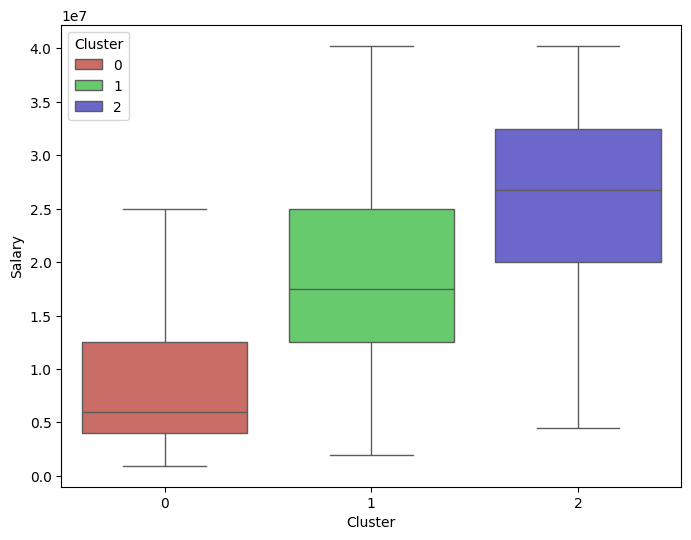

In [53]:
# Plot Salary Distribution for each Cluster
plt.figure(figsize=(8,6))
sns.boxplot(data=jobs_cluster_result, x='Cluster', y='Salary', hue='Cluster', palette=sns.color_palette("hls", K), showfliers=False)
plt.show()

- Plot Level Distribution for each Cluster

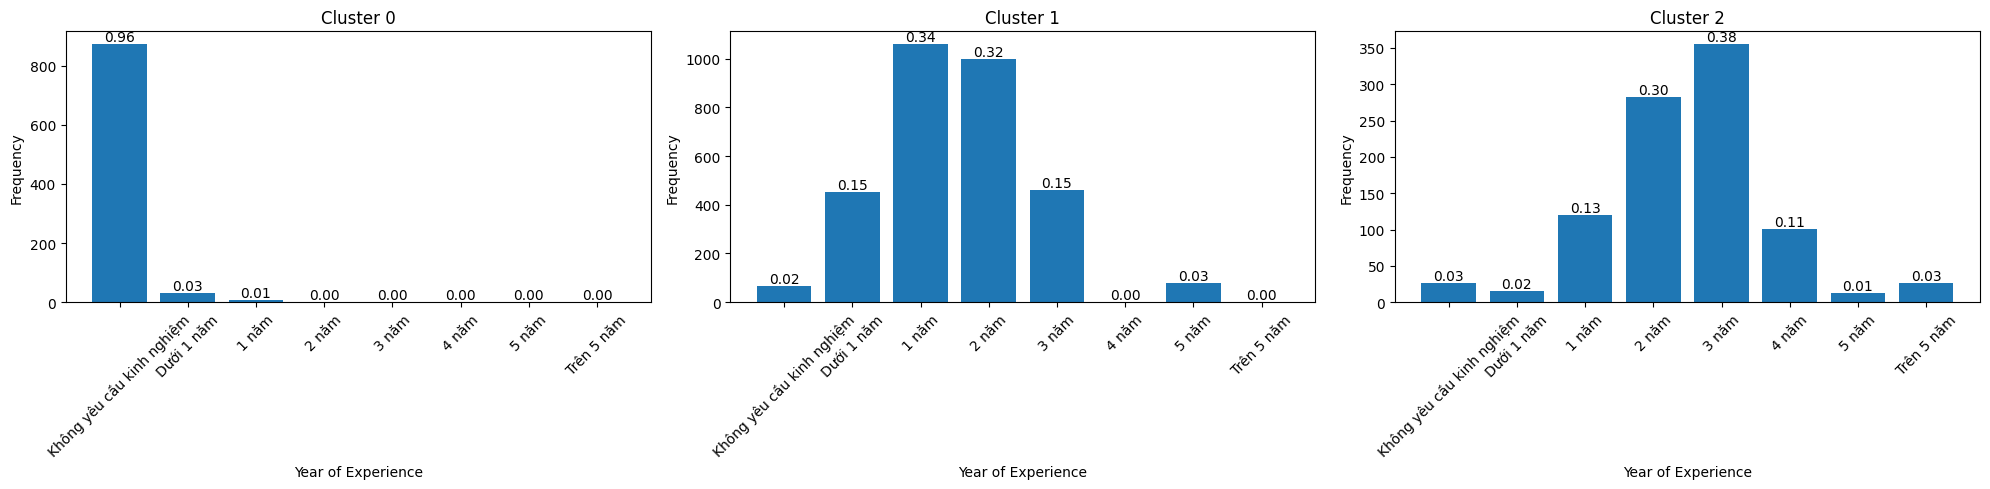

In [54]:
fig, axs = plt.subplots(1, K, figsize=(20, 5))
index = ['Không yêu cầu kinh nghiệm', 'Dưới 1 năm', '1 năm', '2 năm', '3 năm', '4 năm', '5 năm', 'Trên 5 năm']

for i in range(K):
    values = clusters[i]['Year of Experience'].value_counts().reindex(index, fill_value=0)
    axs[i].bar(index, values)
    axs[i].set_title(f'Cluster {i}')
    axs[i].set_xlabel('Year of Experience')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)
    # cho biết tỉ lệ của từng nhóm
    total = values.sum()
    for j, value in enumerate(values):
        axs[i].text(j, value, f'{value/total:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

- Plot Requirement Language Distribution for each Cluster

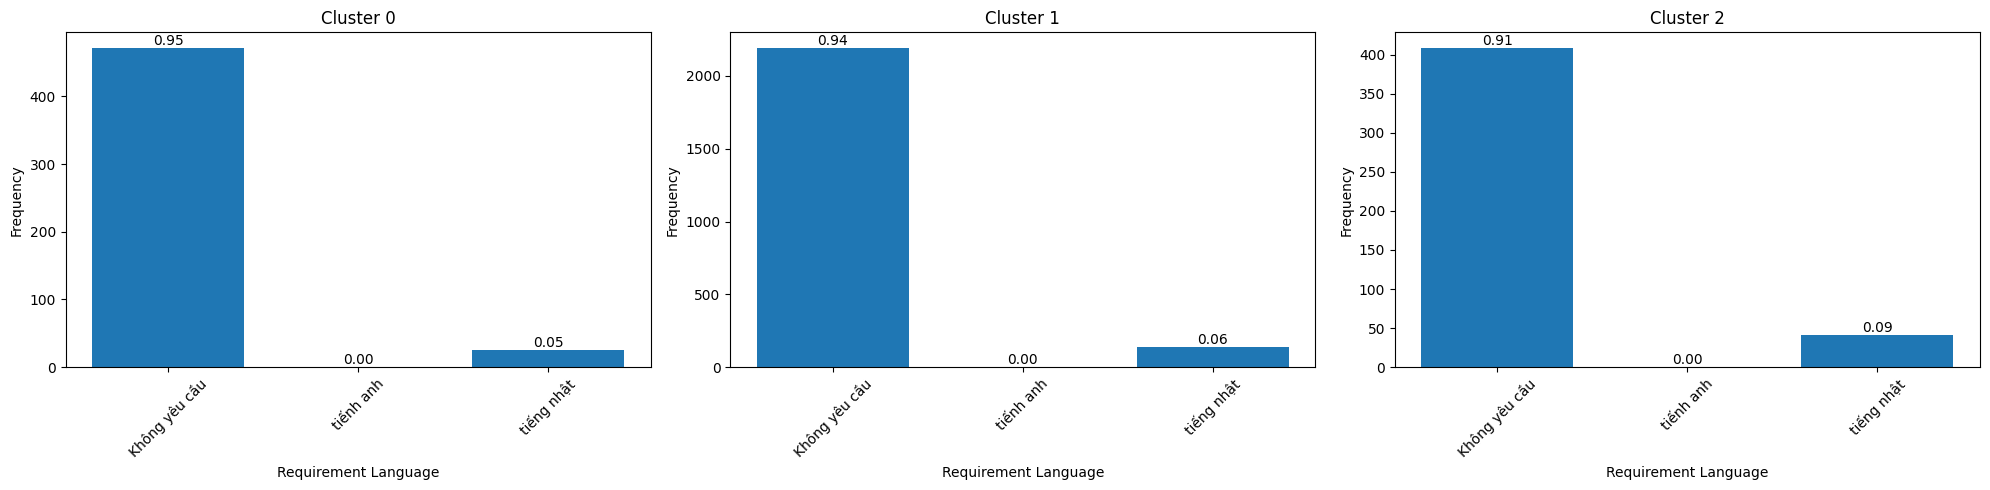

In [55]:
fig, axs = plt.subplots(1, K, figsize=(20, 5))
index = ['Không yêu cầu', 'tiếnh anh', 'tiếng nhật']

for i in range(K):
    values = clusters[i]['Requirement Language'].value_counts().reindex(index, fill_value=0)
    axs[i].bar(index, values)
    axs[i].set_title(f'Cluster {i}')
    axs[i].set_xlabel('Requirement Language')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)
    # cho biết tỉ lệ của từng nhóm
    total = values.sum()
    for j, value in enumerate(values):
        axs[i].text(j, value, f'{value/total:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

- Plot Location Distribution for each Cluster

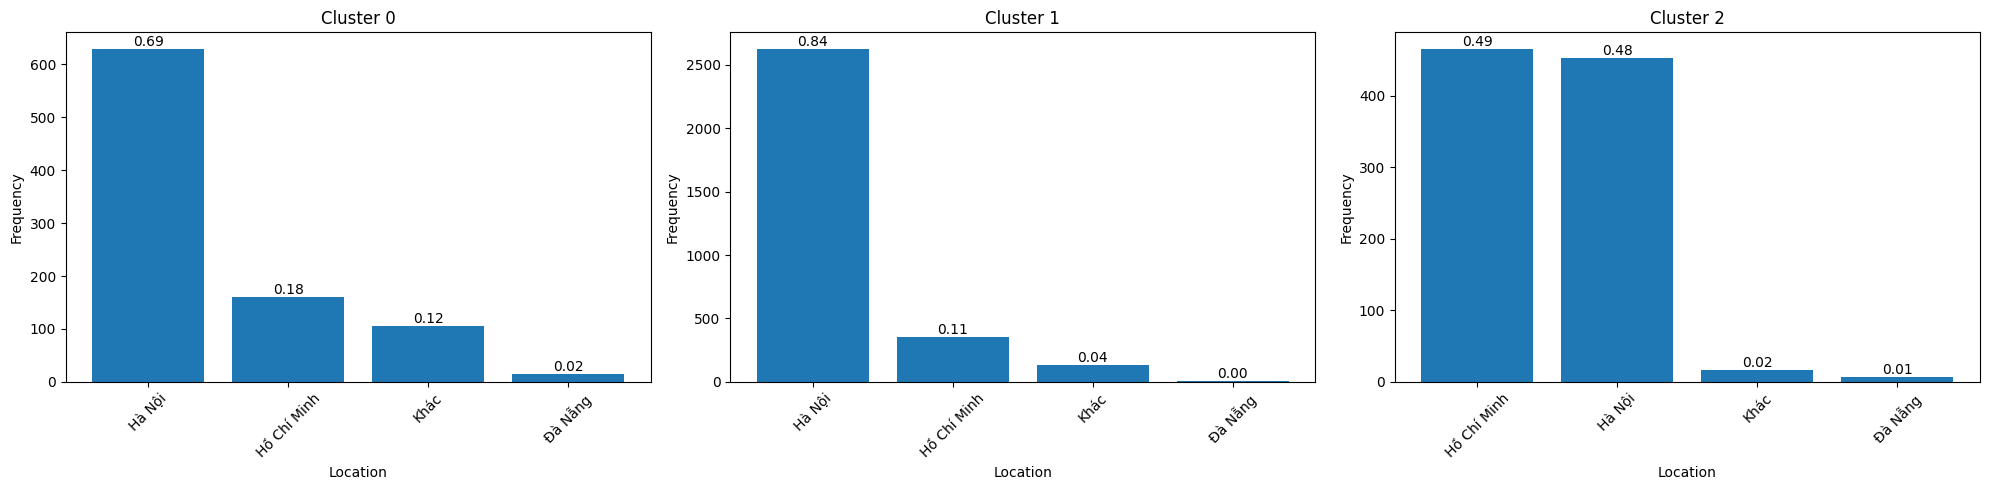

In [56]:
# Vẽ biểu đồ phân phối Location cho từng cụm
fig, axs = plt.subplots(1, K, figsize=(20, 5))

for i in range(K):
    values = clusters[i]['Location'].value_counts()
    axs[i].bar(values.index, values)
    axs[i].set_title(f'Cluster {i}')
    axs[i].set_xlabel('Location')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)
    # cho biết tỉ lệ của từng nhóm
    total = values.sum()
    for j, value in enumerate(values):
        axs[i].text(j, value, f'{value/total:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

- Plot Level Distribution for each Cluster

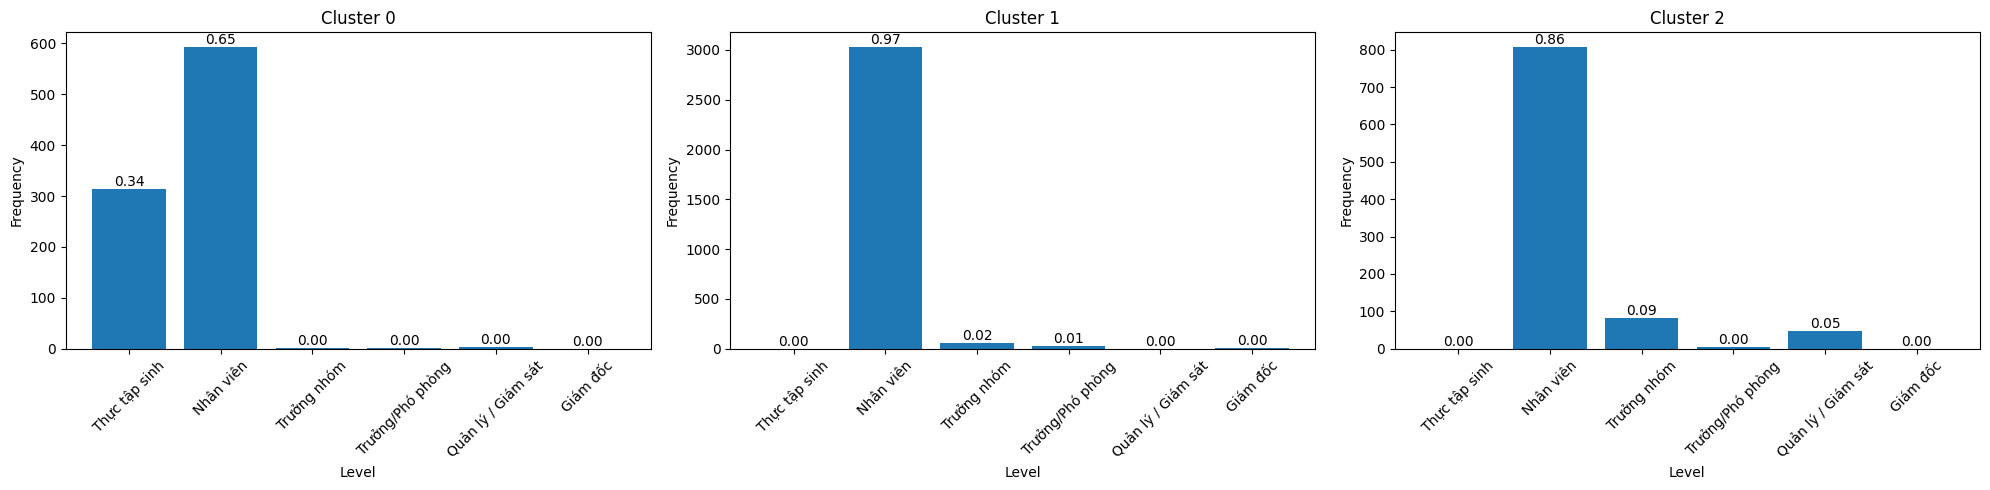

In [57]:
# Vẽ biểu đồ phân phối Level cho từng cụm
fig, axs = plt.subplots(1, K, figsize=(20, 5))
index = ['Thực tập sinh', 'Nhân viên', 'Trưởng nhóm', 'Trưởng/Phó phòng', 'Quản lý / Giám sát', 'Giám đốc']

for i in range(K):
    values = clusters[i]['Level'].value_counts().reindex(index, fill_value=0)
    axs[i].bar(index, values)
    axs[i].set_title(f'Cluster {i}')
    axs[i].set_xlabel('Level')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)
    # cho biết tỉ lệ của từng nhóm
    total = values.sum()
    for j, value in enumerate(values):
        axs[i].text(j, value, f'{value/total:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

- Plot Description Language Distribution for Cluster 

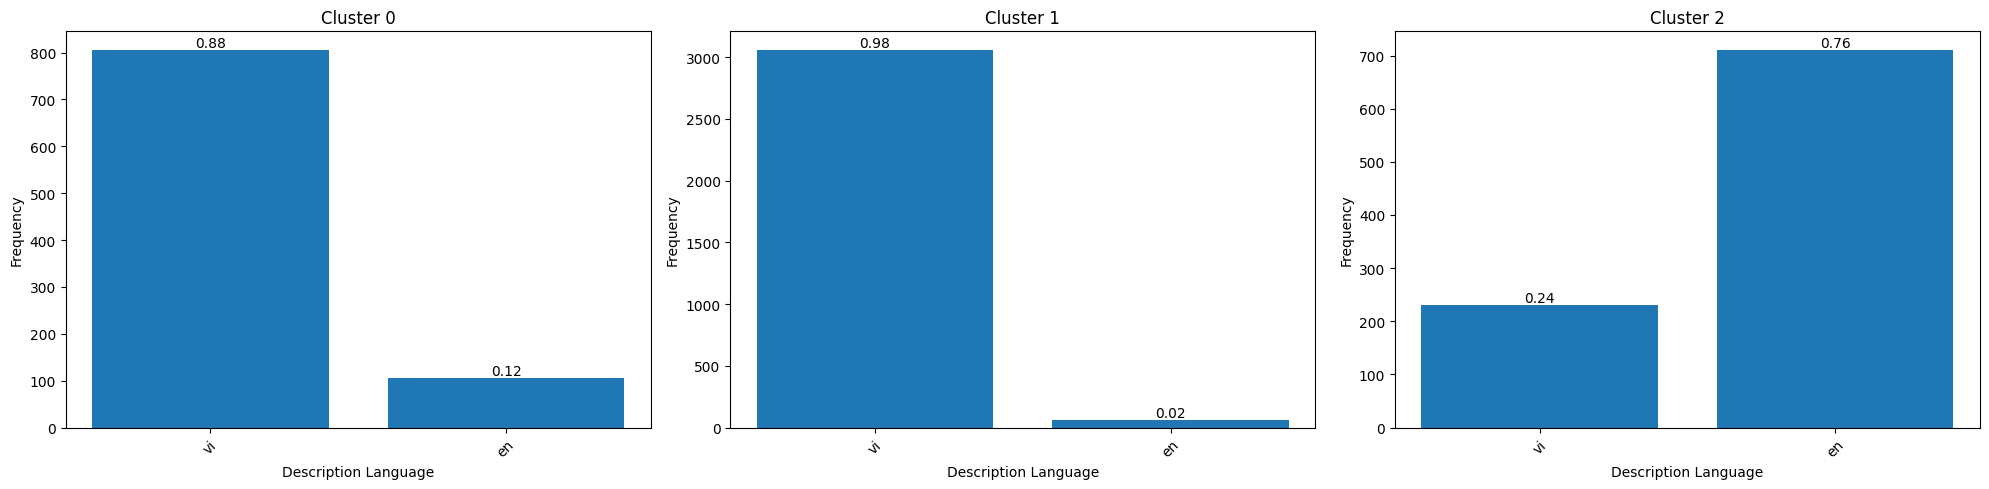

In [58]:
# Vẽ biểu đồ phân phối Description Language cho từng cụm
fig, axs = plt.subplots(1, K, figsize=(20, 5))
index = ['vi', 'en']

for i in range(K):
    values = clusters[i]['Description Language'].value_counts().reindex(index, fill_value=0)
    axs[i].bar(index, values)
    axs[i].set_title(f'Cluster {i}')
    axs[i].set_xlabel('Description Language')
    axs[i].set_ylabel('Frequency')
    axs[i].tick_params(axis='x', rotation=45)
    # cho biết tỉ lệ của từng nhóm
    total = values.sum()
    for j, value in enumerate(values):
        axs[i].text(j, value, f'{value/total:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()